In [2]:
#| default_exp inverse_design

In [3]:
#| exporti
import autograd.numpy as npa
import jax
import jax.numpy as jnp
import matplotlib.pylab as plt
import numpy as np
from ceviche import jacobian
from ceviche.modes import insert_mode
from inverse_design.brushes import notched_square_brush, show_mask
from inverse_design.conditional_generator import (
    new_latent_design,
    transform,
)
from inverse_design.local_generator import (
    generate_feasible_design,
    generate_feasible_design_mask
)
from inverse_design.direct_optimization import huber_loss
from inverse_design.naive_inverse_design import (
    init_domain,
    mask_combine_epsr,
    mode_overlap,
    viz_sim,
)
from jax.example_libraries.optimizers import adam
from tqdm.notebook import trange

> This notebook was adapted from Ceviche's [inverse design introduction](https://github.com/fancompute/workshop-invdesign/blob/master/02_Invdes_intro.ipynb) to use a JAX-based optimization loop in stead of the default Ceviche optimization loop.

## Parameters

Our toy optimization problem will be to design a device that converts an input in the first-order mode into an output as the second-order mode. First, we define the parameters of our device and optimization:

In [31]:
#| exports

# Angular frequency of the source in Hz
omega = 2 * np.pi * 200e12
# Spatial resolution in meters
dl = 40e-9
# Number of pixels in x-direction
Nx = 120
# Number of pixels in y-direction
Ny = 120
# Number of pixels in the PMLs in each direction
Npml = 20
# Initial value of the structure's relative permittivity
epsr_init = 12.0
# Space between the PMLs and the design region (in pixels)
space = 10
# Width of the waveguide (in pixels)
wg_width = 12
# Length in pixels of the source/probe slices on each side of the center point
space_slice = 8
# Number of epochs in the optimization
Nsteps = 100
# Step size for the Adam optimizer
step_size = 1e-2

## Brush

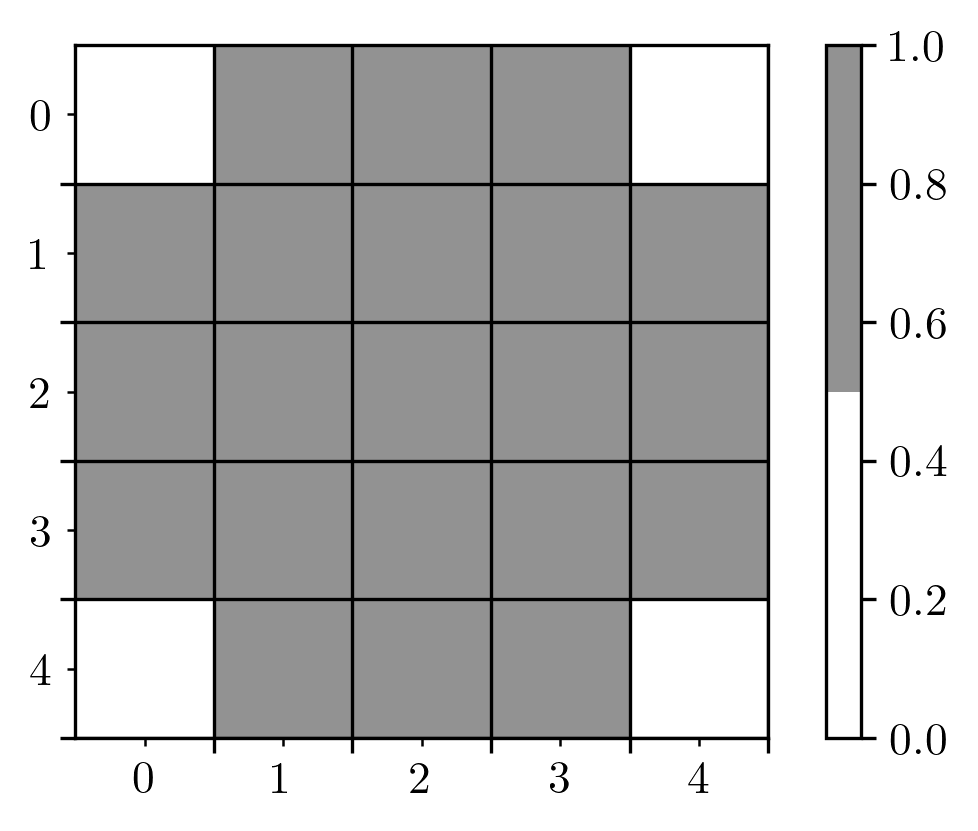

In [32]:
brush = notched_square_brush(5, 1)
show_mask(brush)

## Initial Device

In [33]:
#| exports

# Initialize the parametrization rho and the design region
epsr, bg_epsr, design_region, input_slice, output_slice = init_domain(
    Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice
)

epsr_total = mask_combine_epsr(epsr, bg_epsr, design_region)

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_total, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_total, m=2)

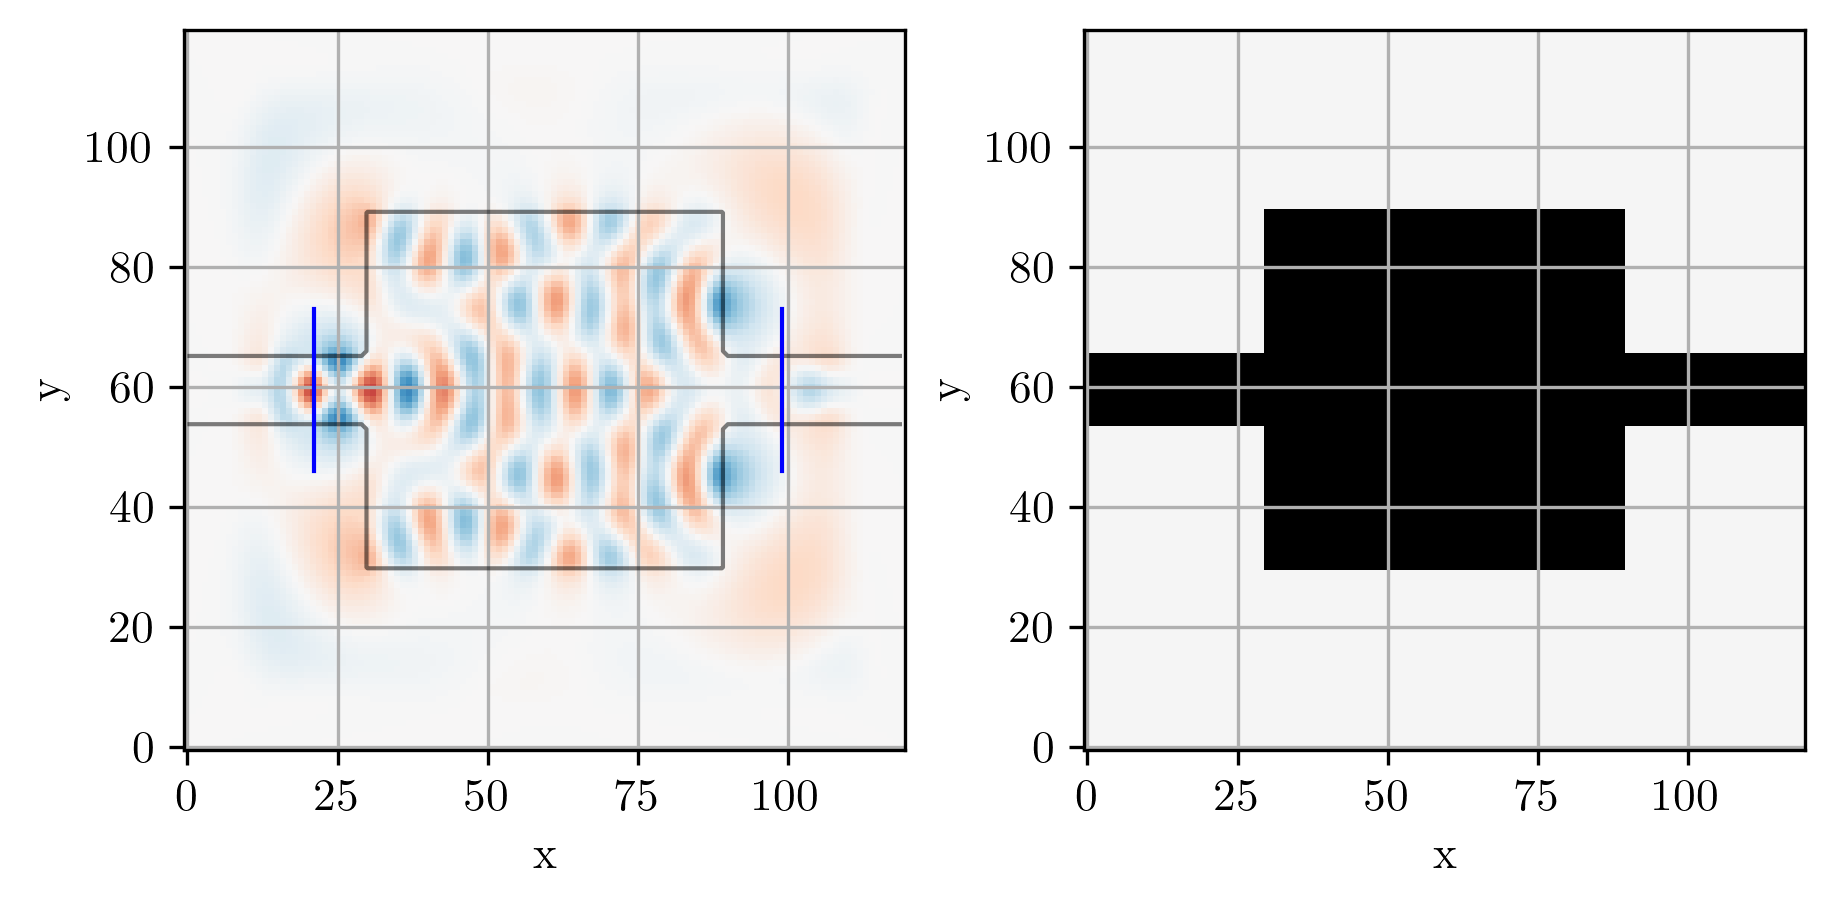

In [34]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

# get normalization factor (field overlap before optimizing)
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

In [35]:
def get_design_region(epsr, design_region=design_region):
    I = np.where(design_region.sum(0) > 1e-5)[0]
    J = np.where(design_region.sum(1) > 1e-5)[0]
    return epsr[I,:][:,J]

In [36]:
def set_design_region(epsr, value, design_region=design_region):
    return np.where(design_region > 1e-5, value, epsr)

## Latent Weights

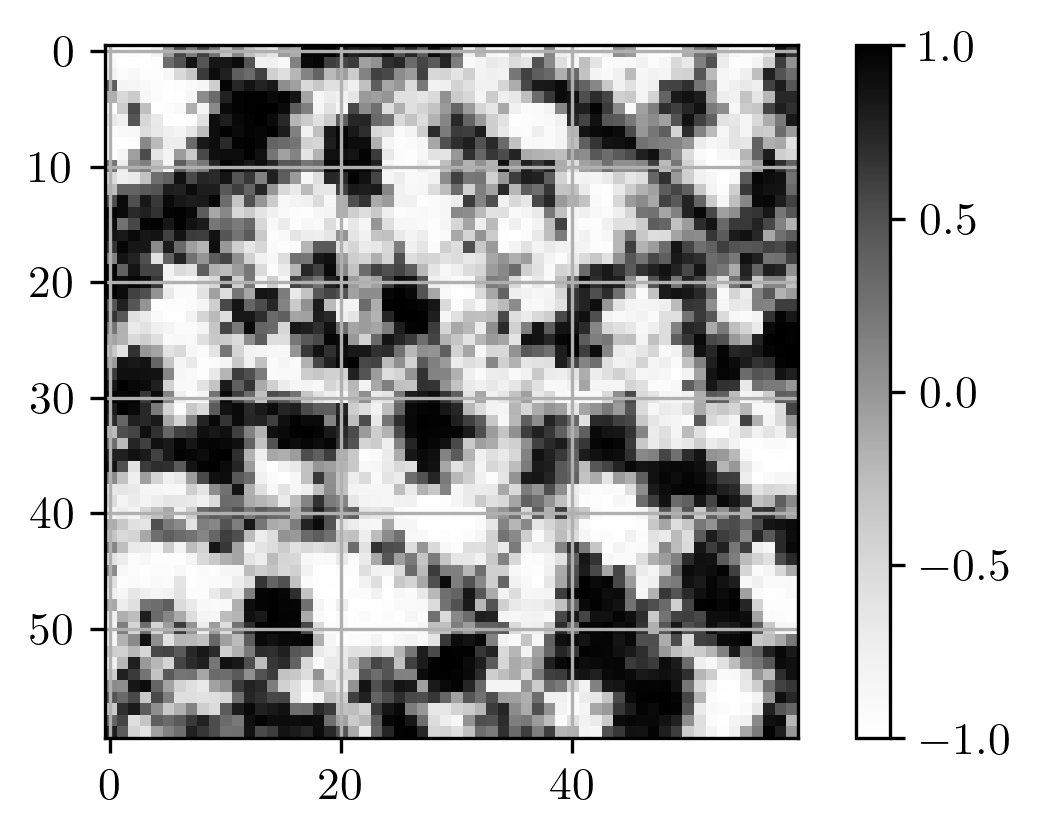

In [37]:
#latent = get_design_region(new_latent_design((Nx, Ny), r=0))
latent = new_latent_design((Nx, Ny), r=0)
latent_t = transform(latent.reshape((Nx, Ny)), brush)
plt.imshow(get_design_region(latent_t), cmap="Greys", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

## Forward Pass

0: valid
1: valid
2: free: 2; 0
3: valid
4: valid
5: valid
6: valid
7: valid
8: valid
9: valid
10: valid
11: valid
12: valid
13: free: 0; 1
14: valid
15: valid
16: free: 2; 0
17: valid
18: valid
19: valid
20: valid
21: valid
22: valid
23: free: 0; 2
24: valid
25: resolving
26: free: 1; 0
27: resolving
28: free: 6; 0
29: valid
30: valid
31: valid
32: valid
33: valid
34: resolving
35: resolving
36: free: 0; 5
37: valid
38: valid
39: valid
40: valid
41: valid
42: resolving
43: free: 0; 8
44: valid
45: valid
46: valid
47: valid
48: valid
49: valid
50: resolving
51: free: 0; 9
52: valid
53: valid
54: valid
55: valid
56: valid
57: valid
58: valid
59: free: 0; 2
60: valid
61: valid
62: valid
63: valid
64: resolving
65: free: 2; 0
66: valid
67: valid
68: valid
69: resolving
70: resolving
71: free: 7; 0
72: valid
73: valid
74: free: 0; 10
75: valid
76: valid
77: valid
78: resolving
79: valid
80: valid
81: resolving
82: free: 0; 7
83: valid
84: valid
85: resolving
86: free: 0; 7
87: valid
88: va

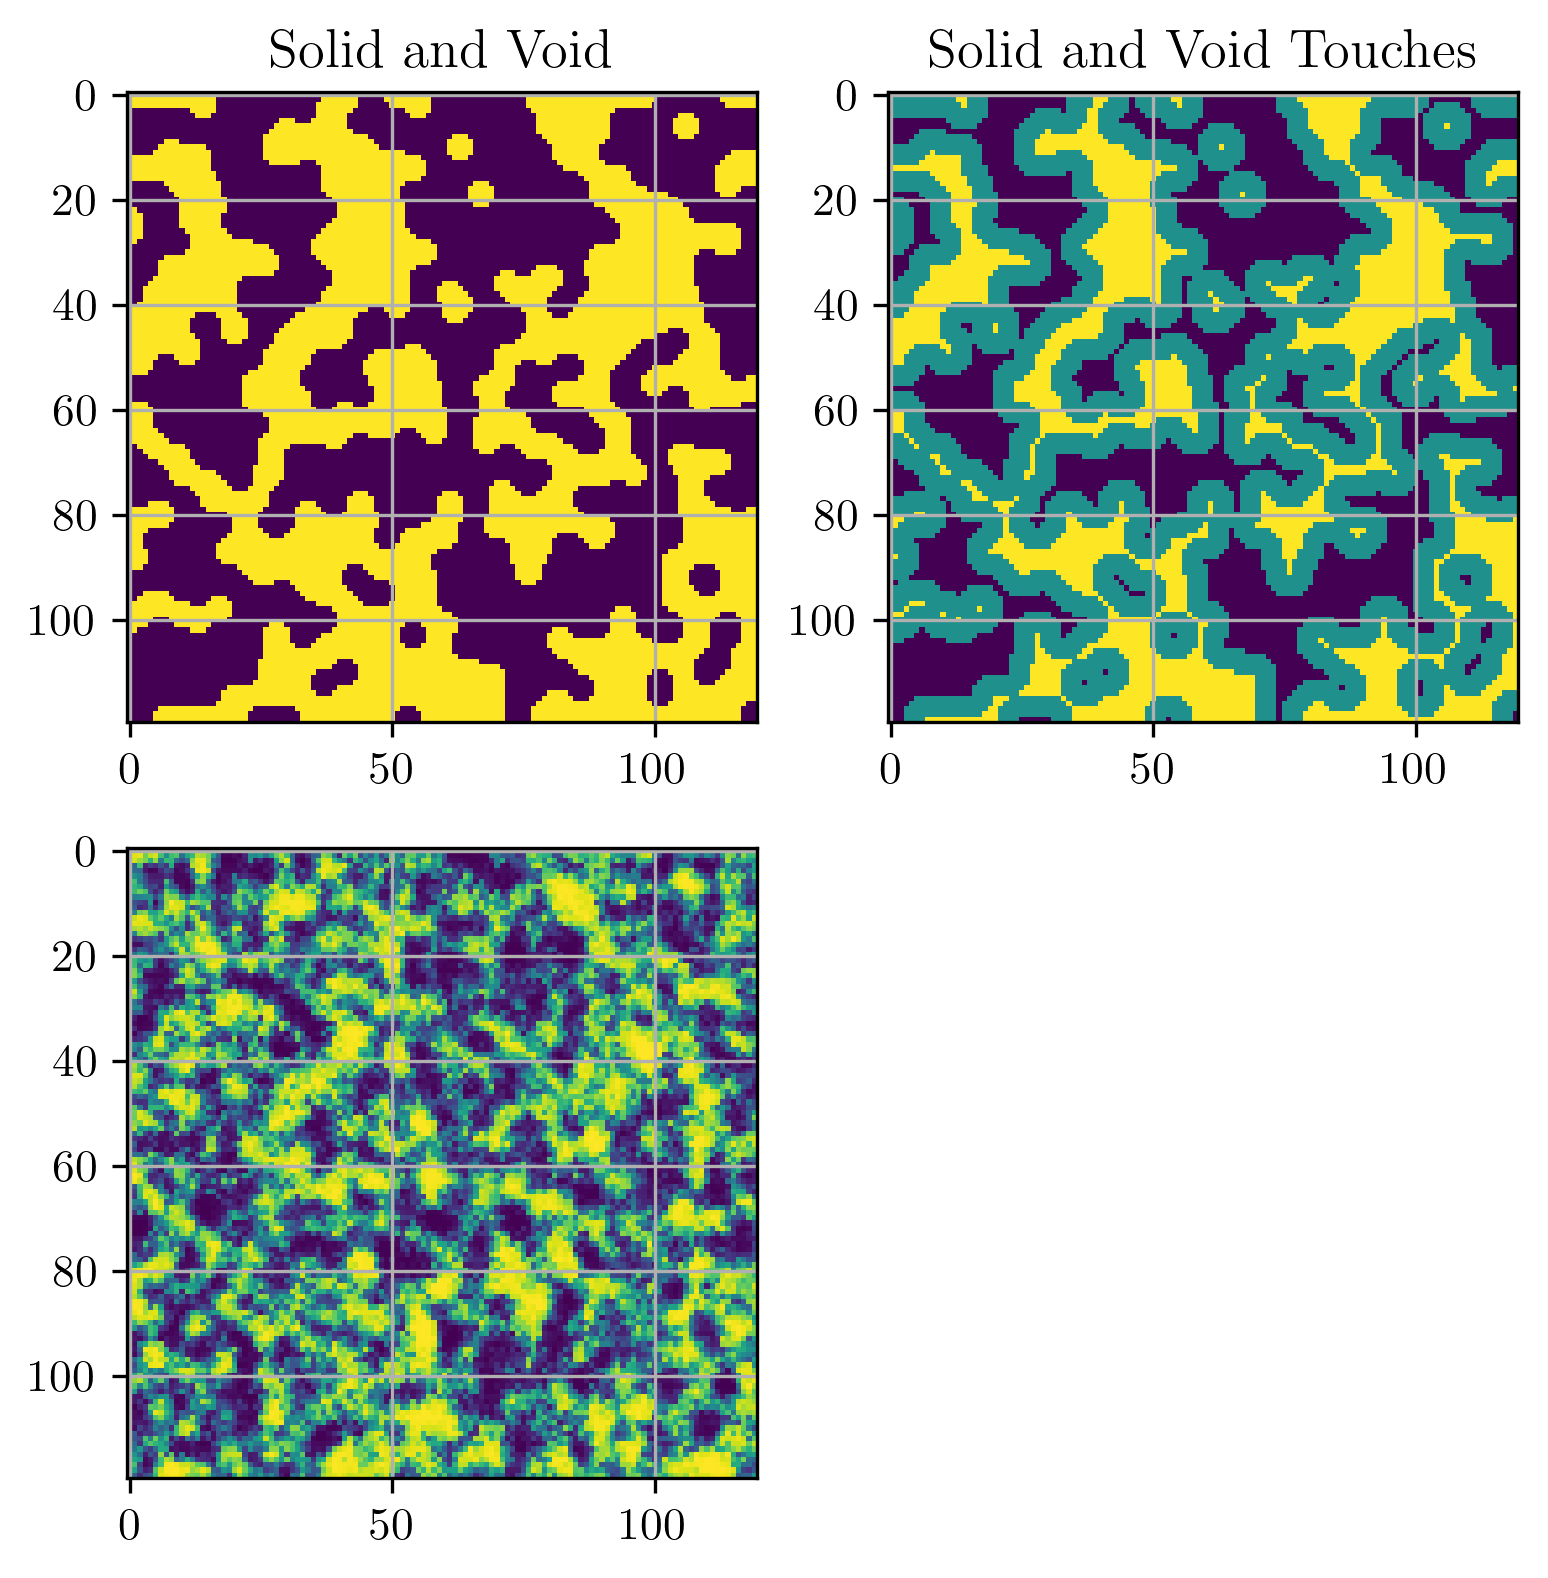

In [38]:
design = generate_feasible_design(latent_t, brush, verbose=True)

In [12]:
mask = generate_feasible_design_mask(latent_t, brush)

CPU times: user 1.65 s, sys: 43.7 ms, total: 1.7 s
Wall time: 1.7 s


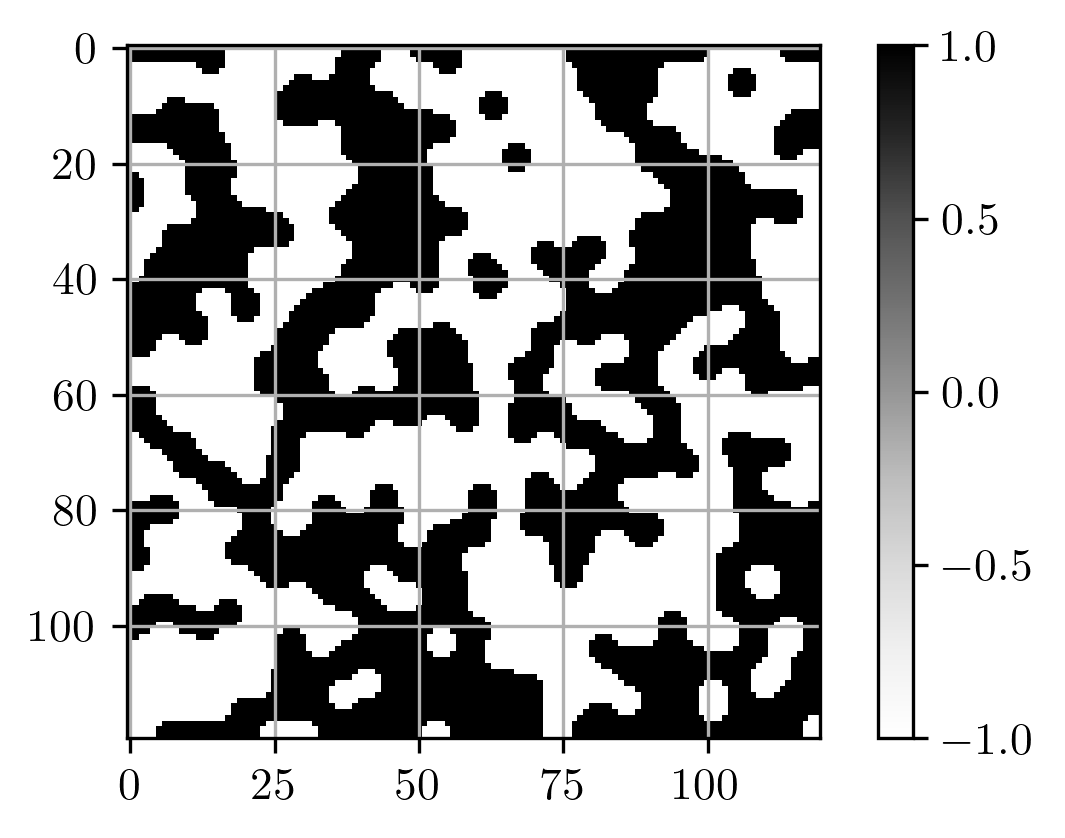

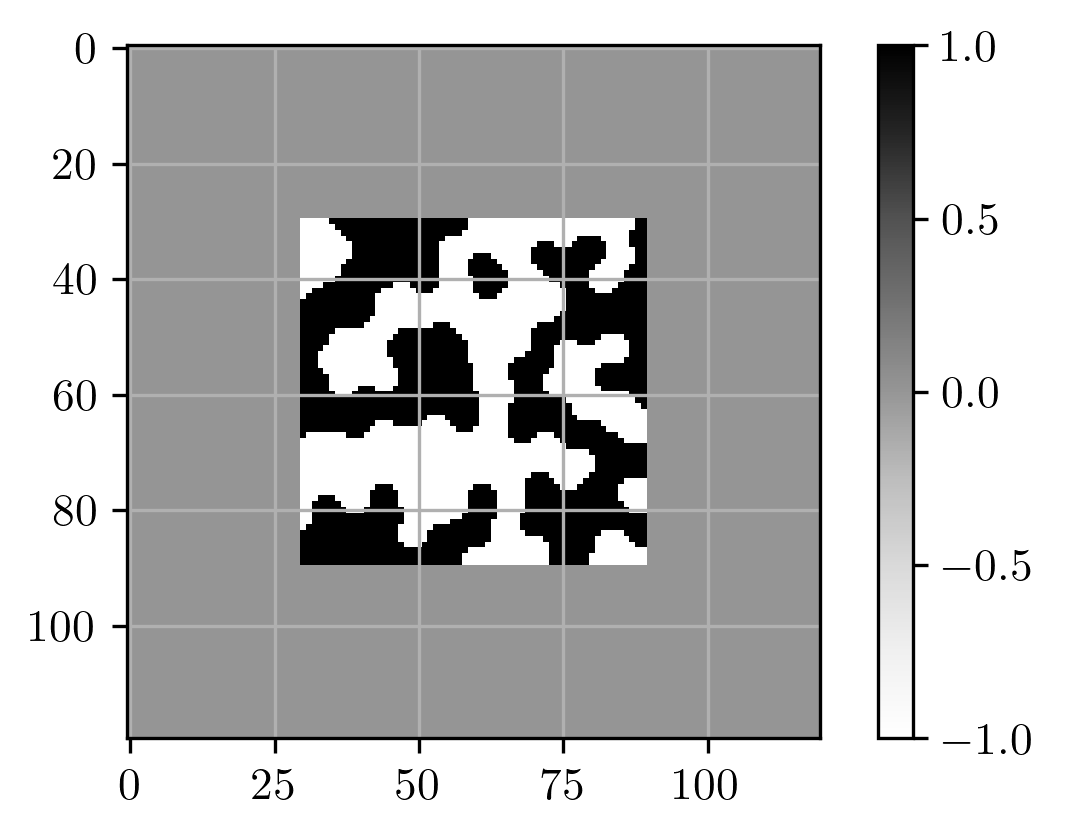

In [39]:
%time mask = generate_feasible_design_mask(latent_t, brush, )
full_mask = np.zeros_like(epsr, dtype=bool)
full_mask = set_design_region(full_mask, mask)

plt.imshow(mask, cmap="Greys")
plt.colorbar()
plt.show()

plt.imshow(full_mask, cmap="Greys")
plt.colorbar()
plt.show()

In [40]:
#| exports
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush)
    design_mask = generate_feasible_design_mask(latent_t, brush)
    epsr = jnp.where(design_mask>0, 12.0, 1.0)
    return epsr

In [41]:
jax.jacobian(forward)(latent, brush)

Array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [42]:
#| exports
def loss_fn(epsr):
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)
    return -mode_overlap(Ez, probe) / E0

In [54]:
#| exports
debug_forward=True
@jax.custom_jvp
def loss_jax(latent):
  eps = forward(latent.reshape((Nx, Ny)), brush)
  if debug_forward:
    plt.figure(figsize=(0.5,0.5), frameon=False)
    plt.imshow(eps)
    plt.axis("off")
    plt.show()
  #eps = np.asarray(eps, dtype=float)
  return loss_fn(eps)

grad_fn = jacobian(loss_fn, mode='reverse')

@loss_jax.defjvp
def loss_jax_jvp(primals, tangents):
  latent = primals[0].reshape((Nx, Ny))
  primals_out = loss_jax(latent)
  latent = np.asarray(latent, dtype=float)
  g = jnp.array(grad_fn(latent))
  
  return primals_out, jnp.dot(g[0],tangents[0][0])  # why does this work?!

jax_grad = jax.value_and_grad(loss_jax)

### Optimization

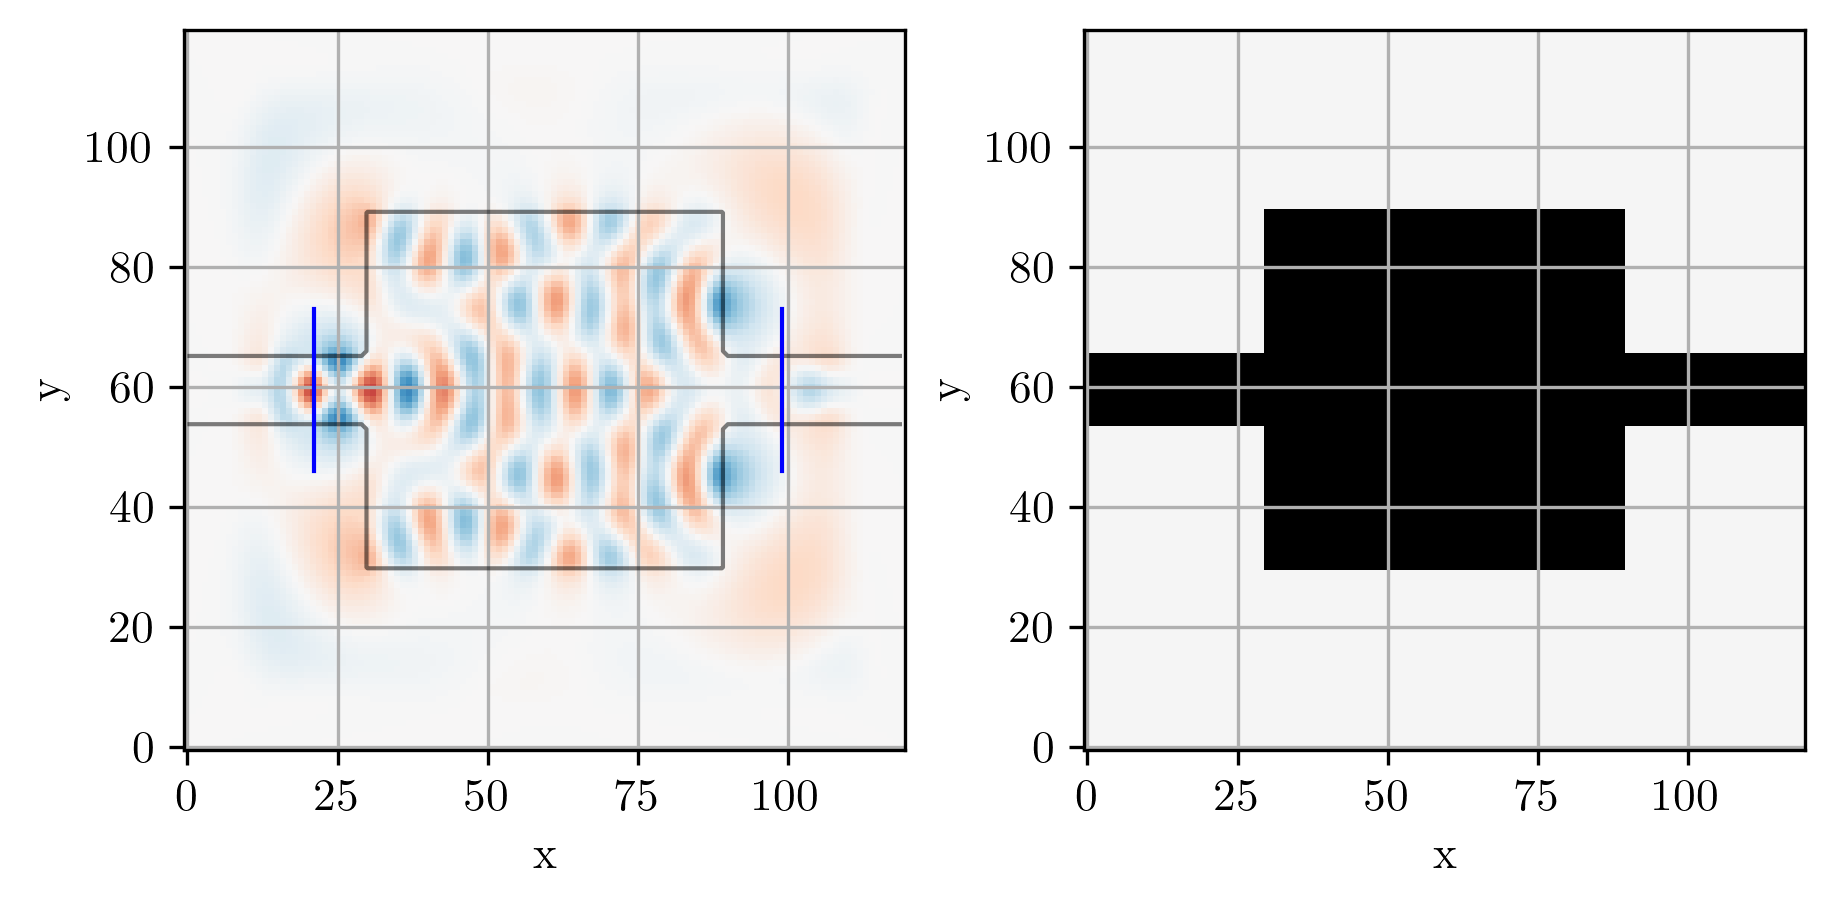

In [44]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])

In [45]:
init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(latent.reshape(1, -1))

this is the optimization step:

In [55]:
#| export
def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    loss, grads = jax_grad(latent)
    optim_state = update_fn(step, grads, state)
    return loss, optim_state

we can now loop over the optimization:

  0%|          | 0/500 [00:00<?, ?it/s]

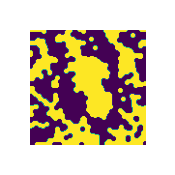

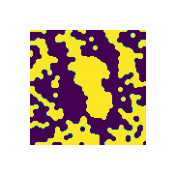

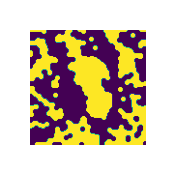

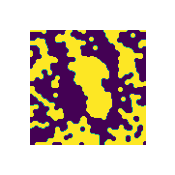

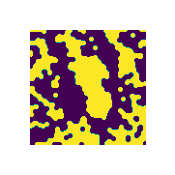

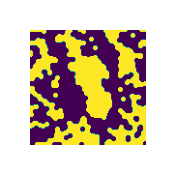

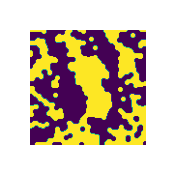

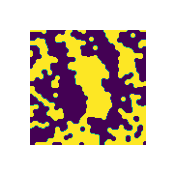

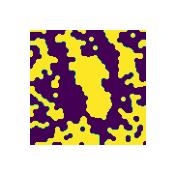

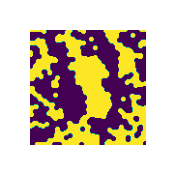

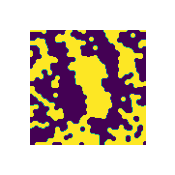

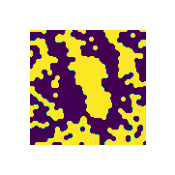

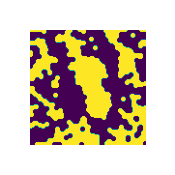

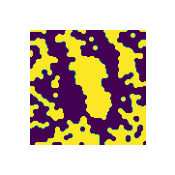

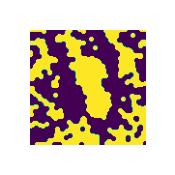

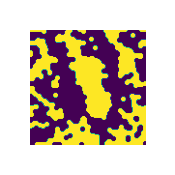

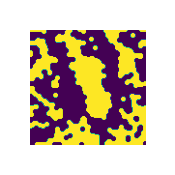

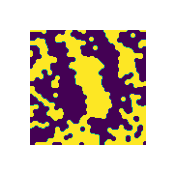

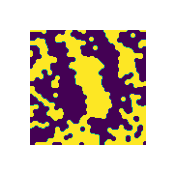

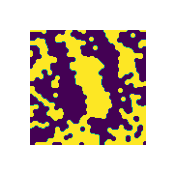

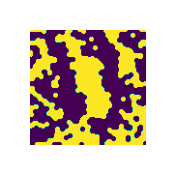

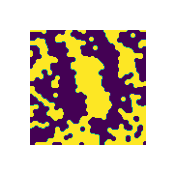

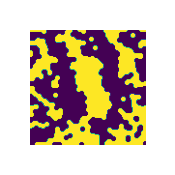

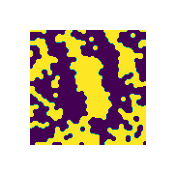

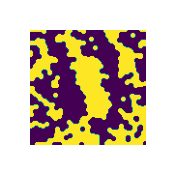

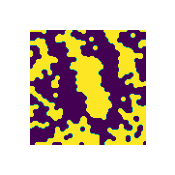

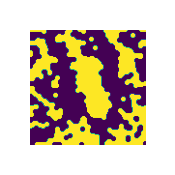

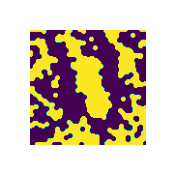

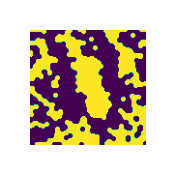

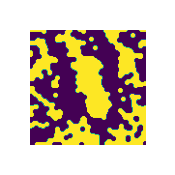

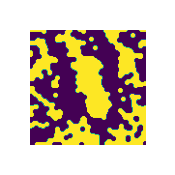

KeyboardInterrupt: 

In [56]:
range_ = trange(500)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=float(loss))

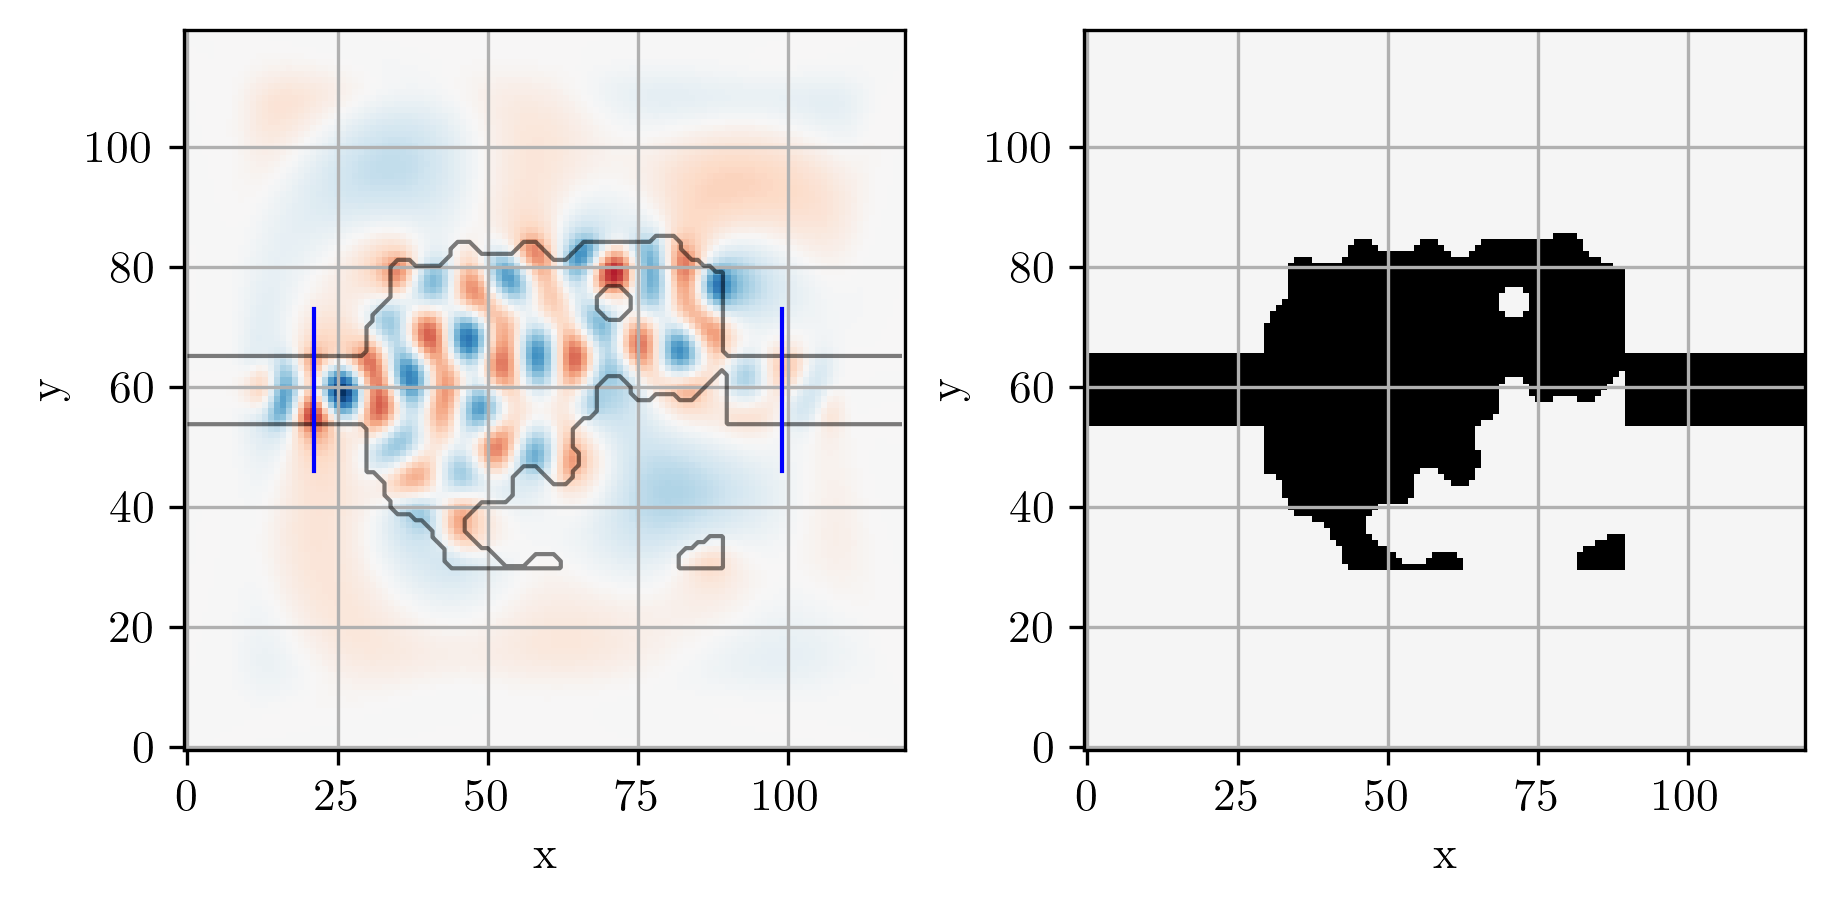

In [57]:
# Simulate and show the optimal device
epsr_optimum = forward(params_fn(state).reshape((Nx,Ny)), brush)
epsr_optimum_total = mask_combine_epsr(epsr_optimum, bg_epsr, design_region)
simulation, ax = viz_sim(epsr_optimum_total, source, slices=[input_slice, output_slice])

At the end of the optimization we can see our final device. From the field pattern, we can easily observe that the device is doing what we intend: the *even* mode enters from the left and exits as the *odd* mode on the right.

However, an additional observation is that our device's permittivity changes continuously. This is not ideal if we wanted to fabricated our device. We're also not constraining the minimum and maximum values of $\epsilon_r$. Thus, we need to consider alternative ways of parameterizing our device.

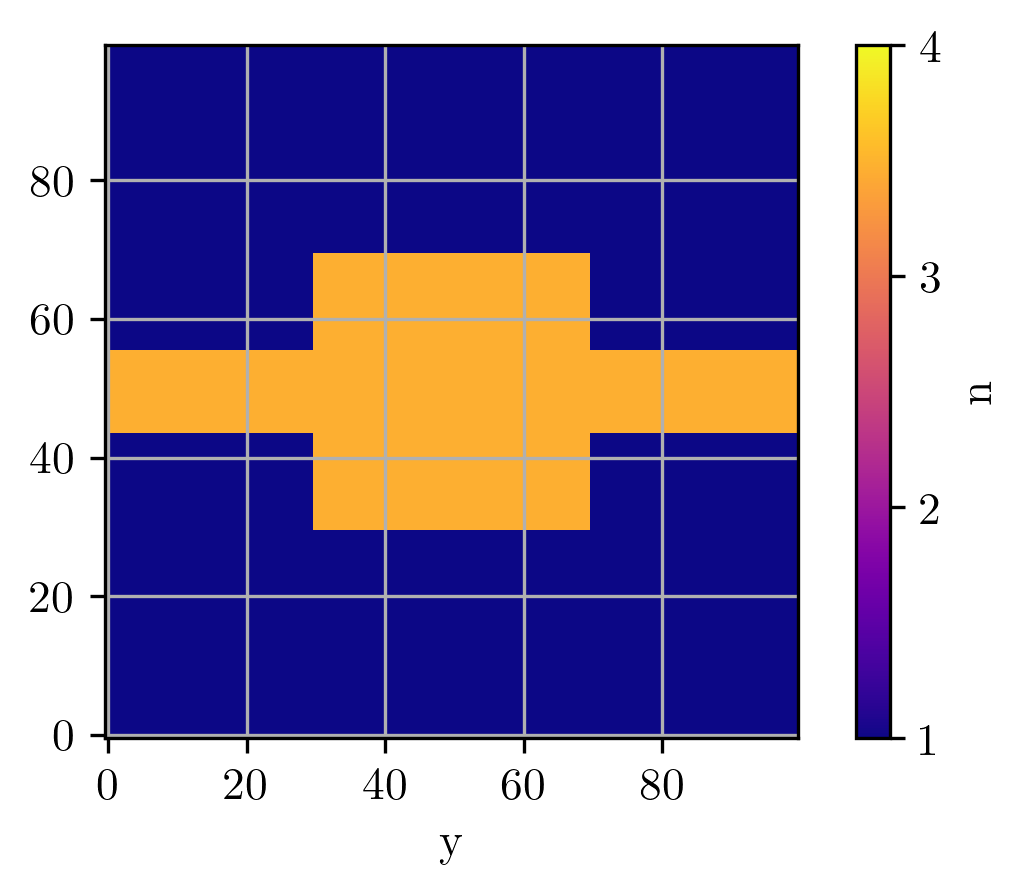

In [ ]:
plt.imshow(np.sqrt(epsr_optimum_total.T), cmap="plasma", vmin=1, vmax=4)
plt.ylim(*plt.ylim()[::-1])
plt.colorbar(ticks=[1,2,3,4], label="n")
plt.xlabel("x")
plt.xlabel("y")
plt.grid(True)